# Andreas Vrachimis - 2380007

## Part A: Post Sentiment Classification ##

In [ ]:
import pandas as pd
import numpy as np

train_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_train.json")

validation_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_validation.json")

test_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_sentiment_test.json")

In [ ]:
### The one_hot_vectorizer from the labs
import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')

#@Tokenize
def spacy_tokenize(string):
  tokens = list()
  doc = nlp(string)
  for token in doc:
    tokens.append(token)
  return tokens

#@Normalize
def normalize(tokens):
  normalized_tokens = list()
  for token in tokens:
    normalized = token.text.lower().strip()
    if ((token.is_alpha or token.is_digit)):
      normalized_tokens.append(normalized)
  return normalized_tokens
  return normalized_tokens

#@Tokenize and normalize
def tokenize_normalize(string):
  return normalize(spacy_tokenize(string))

from sklearn.feature_extraction.text import CountVectorizer

one_hot_vectorizer = CountVectorizer( tokenizer = tokenize_normalize, binary=True, max_features=20000 )

In [ ]:
# Your code here
validation_data.head(20)

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity
0,hearthstone,"The Hearthstone Saloon, my 2015 Blizzard Stude...",t3_2somy1,https://www.reddit.com/r/hearthstone/comments/...,Seradin,http://imgur.com/a/qmVd2\n\nThis is my entry f...,announcement,True,0,,very positive,1.000000
1,hearthstone,"The Hearthstone Saloon, my 2015 Blizzard Stude...",t1_cnrnkw7,https://www.reddit.com/r/hearthstone/comments/...,_ae_,Cool stuff.\n\nOnly thing that stood out to me...,elaboration,False,1,t3_2somy1,neutral,0.550000
2,hearthstone,"The Hearthstone Saloon, my 2015 Blizzard Stude...",t1_cnrjdx5,https://www.reddit.com/r/hearthstone/comments/...,Jrod22too,Kinda awesome. What did you do it in?,question,False,1,t3_2somy1,very positive,1.000000
3,hearthstone,"The Hearthstone Saloon, my 2015 Blizzard Stude...",t1_cnrk704,https://www.reddit.com/r/hearthstone/comments/...,Seradin,"I used Maya, 3DCoat, Photoshop, and Unreal!",answer,False,2,t1_cnrjdx5,neutral,0.000000
4,hearthstone,"The Hearthstone Saloon, my 2015 Blizzard Stude...",t1_cnru9mr,https://www.reddit.com/r/hearthstone/comments/...,Jrod22too,Awesome job.,appreciation,False,3,t1_cnrk704,very positive,1.000000
5,hearthstone,"The Hearthstone Saloon, my 2015 Blizzard Stude...",t1_cnrom2e,https://www.reddit.com/r/hearthstone/comments/...,Aleirri,that's awesome! wp =),appreciation,False,1,t3_2somy1,very positive,1.000000
6,hearthstone,"The Hearthstone Saloon, my 2015 Blizzard Stude...",t1_cnrsuo9,https://www.reddit.com/r/hearthstone/comments/...,VanFkingHalen,This is very cool.,appreciation,False,1,t3_2somy1,positive,0.845000
7,hearthstone,"The Hearthstone Saloon, my 2015 Blizzard Stude...",t1_cnrtmv2,https://www.reddit.com/r/hearthstone/comments/...,Snics,very cool :),appreciation,False,1,t3_2somy1,positive,0.922500
8,hearthstone,"The Hearthstone Saloon, my 2015 Blizzard Stude...",t1_cnrhjdl,https://www.reddit.com/r/hearthstone/comments/...,VG-Rahkwal,Might just be me but the frog looks completely...,elaboration,False,1,t3_2somy1,neutral,0.404444
9,explainlikeimfive,ELI5:How do fast food places get away with say...,t3_32w1hg,https://www.reddit.com/r/explainlikeimfive/com...,LaotianBrute,I always see commercials where they advertise ...,question,True,0,,positive,0.550000


## Q1

Labels


In [ ]:
train_labels = train_data['sentiment.polarity']
validation_labels = validation_data['sentiment.polarity']
test_labels = test_data['sentiment.polarity']

Train Validation Test Split

In [ ]:
len_train = train_labels.size
len_validation = validation_labels.size
len_test = test_labels.size
dataset_size = len_train+len_validation+len_test
print("Train Percentage: {:.2f}%".format(((len_train)/dataset_size)*100))
print("Validation Percentage: {:.2f}%".format((len_validation/(dataset_size))*100))
print("Test Percentage: {:.2f}%\n".format((len_test/dataset_size)*100))

Train Percentage: 63.01%
Validation Percentage: 16.14%
Test Percentage: 20.85%



Labels Distributions

In [ ]:
labels = ['neutral','positive','negative','very positive','very negative']
# Train Set
# print("Train Set\n---------")
labels_counts = train_labels.value_counts()
total = train_labels.size
train = []
for i,count in enumerate(labels_counts):
  #print("{}:{:.2f}%".format(labels[i], (count/total)*100))
  train.append(count/total*100)

# Validation Set
# print("\nValidation Set\n---------")
labels_counts = validation_labels.value_counts()
total = validation_labels.size
validation=[]
for i,count in enumerate(labels_counts):
  #print("{}:{:.2f}%".format(labels[i], (count/total)*100))
  validation.append(count/total*100)


# Test Set
# print("\nTest Set\n---------")
labels_counts = test_labels.value_counts()
total = test_labels.size
test=[]
for i,count in enumerate(labels_counts):
  #print("{}:{:.2f}%".format(labels[i], (count/total)*100))
  test.append(count/total*100)


distribution = {'Train Set': train, 'Validation Set': validation, 'Test Set':test}
df = pd.DataFrame.from_dict(distribution)
df.index = labels
df.round(2)

,Train Set,Validation Set,Test Set
neutral,63.26,63.07,62.60
positive,26.62,27.18,27.44
negative,7.23,6.92,7.02
very positive,2.08,2.35,2.14
very negative,0.80,0.48,0.80


### Vectorization <br>


1.   One Hot Encoding Vectorization
2.   TF - IDF Vectorization



In [ ]:
# 1. One Hot

train_features_one_hot = one_hot_vectorizer.fit_transform(train_data['body'])

validation_features_one_hot = one_hot_vectorizer.transform(validation_data['body'])
test_features_one_hot = one_hot_vectorizer.transform(test_data['body'])

In [ ]:
# 2. TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorizer = TfidfVectorizer( tokenizer = tokenize_normalize, binary=True, max_features=20000 )

train_features_tf_idf = tf_idf_vectorizer.fit_transform(train_data['body'])

validation_features_tf_idf = tf_idf_vectorizer.transform(validation_data['body'])
test_features_tf_idf = tf_idf_vectorizer.transform(test_data['body'])

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

Function from lab 4 used to evaluate the models created

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def evaluation_summary(description, predictions, true_labels,print_report=True):
  if print_report:
    print("Evaluation for: " + description)
  precision = precision_score(predictions, true_labels, average='macro')
  recall = recall_score(predictions, true_labels,average='macro')
  accuracy = accuracy_score(predictions, true_labels)
  f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
  print("Classifier '%s' has \t Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
  if print_report:
    print(classification_report(predictions, true_labels, digits=3))
    print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions)) # Note the order here is true, predicted



### a) Dummy Classifier with strategy = "most frequent"

In [ ]:
from sklearn.dummy import DummyClassifier

mf_classifier = DummyClassifier(strategy="most_frequent")
mf_model = mf_classifier.fit(train_features_one_hot,train_labels)

evaluation_summary("Train Dataset:      Dummy Classifier Most Frequent", mf_model.predict(train_features_one_hot) , train_labels,print_report=False)
evaluation_summary("Validation Dataset: Dummy Classifier Most Frequent", mf_model.predict(validation_features_one_hot) , validation_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier 'Train Dataset:      Dummy Classifier Most Frequent' has 	 Acc=0.633 P=0.200 R=0.127 F1=0.155
Evaluation for: Validation Dataset: Dummy Classifier Most Frequent
Classifier 'Validation Dataset: Dummy Classifier Most Frequent' has 	 Acc=0.631 P=0.200 R=0.126 F1=0.155
               precision    recall  f1-score   support

     negative      0.000     0.000     0.000         0
      neutral      1.000     0.631     0.774      3109
     positive      0.000     0.000     0.000         0
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.631      3109
    macro avg      0.200     0.126     0.155      3109
 weighted avg      1.000     0.631     0.774      3109


Confusion matrix:
 [[   0  215    0    0    0]
 [   0 1961    0    0    0]
 [   0  845    0    0    0]
 [   0   15    0    0    0]
 [   0   73    0    0    0]]


### b) Dummy Classifier with strategy = "stratified"


In [ ]:
stra_classifier = DummyClassifier(strategy="stratified")
stra_model = stra_classifier.fit(train_features_one_hot,train_labels)

evaluation_summary("Train Dataset:      Dummy Classifier Stratified",  stra_model.predict(train_features_one_hot), train_labels, print_report=False)
evaluation_summary("Validation Dataset: Dummy Classifier Stratified",  stra_model.predict(validation_features_one_hot), validation_labels)

Classifier 'Train Dataset:      Dummy Classifier Stratified' has 	 Acc=0.480 P=0.205 R=0.206 F1=0.205
Evaluation for: Validation Dataset: Dummy Classifier Stratified
Classifier 'Validation Dataset: Dummy Classifier Stratified' has 	 Acc=0.474 P=0.204 R=0.205 F1=0.204
               precision    recall  f1-score   support

     negative      0.056     0.050     0.053       240
      neutral      0.628     0.628     0.628      1962
     positive      0.266     0.279     0.273       806
very negative      0.000     0.000     0.000        29
very positive      0.068     0.069     0.069        72

     accuracy                          0.474      3109
    macro avg      0.204     0.205     0.204      3109
 weighted avg      0.471     0.474     0.473      3109


Confusion matrix:
 [[  12  148   49    4    2]
 [ 147 1232  515   21   46]
 [  76  521  225    4   19]
 [   1    9    5    0    0]
 [   4   52   12    0    5]]


### c) Logistic Regression with One-hot vectorization

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_classifier_one_hot = LogisticRegression(max_iter=1000)
lr_model_one_hot = lr_classifier_one_hot.fit(train_features_one_hot,train_labels)

evaluation_summary("Train Dataset:      Logistic Regression with One Hot",  lr_model_one_hot.predict(train_features_one_hot), train_labels,print_report=False)
evaluation_summary("Validation Dataset: Logistic Regression with One Hot",  lr_model_one_hot.predict(validation_features_one_hot), validation_labels)

Classifier 'Train Dataset:      Logistic Regression with One Hot' has 	 Acc=0.963 P=0.839 R=0.982 F1=0.897
Evaluation for: Validation Dataset: Logistic Regression with One Hot
Classifier 'Validation Dataset: Logistic Regression with One Hot' has 	 Acc=0.751 P=0.460 R=0.630 F1=0.513
               precision    recall  f1-score   support

     negative      0.256     0.505     0.340       109
      neutral      0.881     0.780     0.828      2214
     positive      0.619     0.702     0.658       745
very negative      0.200     0.429     0.273         7
very positive      0.342     0.735     0.467        34

     accuracy                          0.751      3109
    macro avg      0.460     0.630     0.513      3109
 weighted avg      0.789     0.751     0.765      3109


Confusion matrix:
 [[  55  152    7    1    0]
 [  48 1728  177    3    5]
 [   5  313  523    0    4]
 [   1   11    0    3    0]
 [   0   10   38    0   25]]


### d) Logistic Regression with TF-IDF vectorization

In [ ]:
lr_classifier_tf_idf = LogisticRegression(max_iter=1000)

lr_model_tf_idf = lr_classifier_tf_idf.fit(train_features_tf_idf,train_labels)

evaluation_summary("Train Dataset:      Logistic Regression with TF-IDF",  lr_model_tf_idf.predict(train_features_tf_idf), train_labels,print_report = False)
evaluation_summary("Validation Dataset: Logistic Regression with TF-IDF",  lr_model_tf_idf.predict(validation_features_tf_idf), validation_labels)

Classifier 'Train Dataset:      Logistic Regression with TF-IDF' has 	 Acc=0.824 P=0.423 R=0.918 F1=0.477
Evaluation for: Validation Dataset: Logistic Regression with TF-IDF
Classifier 'Validation Dataset: Logistic Regression with TF-IDF' has 	 Acc=0.730 P=0.334 R=0.593 F1=0.365
               precision    recall  f1-score   support

     negative      0.107     0.697     0.185        33
      neutral      0.924     0.739     0.821      2453
     positive      0.503     0.696     0.584       611
very negative      0.000     0.000     0.000         0
very positive      0.137     0.833     0.235        12

     accuracy                          0.730      3109
    macro avg      0.334     0.593     0.365      3109
 weighted avg      0.830     0.730     0.765      3109


Confusion matrix:
 [[  23  187    5    0    0]
 [   7 1812  141    0    1]
 [   1  418  425    0    1]
 [   2   13    0    0    0]
 [   0   23   40    0   10]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### e) SVC Classifier with One-hot vectorization 

In [ ]:
from sklearn.svm import SVC
svc_classifier = SVC(kernel='rbf')
svc_model_one_hot = svc_classifier.fit(train_features_one_hot,train_labels)

evaluation_summary("Train Dataset:      SVC Classifier with One Hot",  svc_model_one_hot.predict(train_features_one_hot), train_labels,print_report=False)
evaluation_summary("Validation Dataset: SVC Classifier with One Hot",  svc_model_one_hot.predict(validation_features_one_hot), validation_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier 'Train Dataset:      SVC Classifier with One Hot' has 	 Acc=0.862 P=0.423 R=0.751 F1=0.455
Evaluation for: Validation Dataset: SVC Classifier with One Hot
Classifier 'Validation Dataset: SVC Classifier with One Hot' has 	 Acc=0.722 P=0.285 R=0.423 F1=0.284
               precision    recall  f1-score   support

     negative      0.019     0.667     0.036         6
      neutral      0.944     0.721     0.818      2567
     positive      0.463     0.729     0.566       536
very negative      0.000     0.000     0.000         0
very positive      0.000     0.000     0.000         0

     accuracy                          0.722      3109
    macro avg      0.285     0.423     0.284      3109
 weighted avg      0.859     0.722     0.773      3109


Confusion matrix:
 [[   4  208    3    0    0]
 [   1 1851  109    0    0]
 [   1  453  391    0    0]
 [   0   15    0    0    0]
 [   0   40   33    0    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### f) Random Forest Classifier with TF-IDF Vectorization

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier()
random_forest_model = random_forest_classifier.fit(train_features_tf_idf,train_labels)

evaluation_summary("Train Dataset:      Random Forest Classifier with TF-IDF",  random_forest_model.predict(train_features_tf_idf), train_labels,print_report = False)
evaluation_summary("Validation Dataset: Random Forest Classifier with TF-IDF",  random_forest_model.predict(validation_features_tf_idf), validation_labels)

Classifier 'Train Dataset:      Random Forest Classifier with TF-IDF' has 	 Acc=0.999 P=0.994 R=0.999 F1=0.996
Evaluation for: Validation Dataset: Random Forest Classifier with TF-IDF
Classifier 'Validation Dataset: Random Forest Classifier with TF-IDF' has 	 Acc=0.706 P=0.327 R=0.701 F1=0.363
               precision    recall  f1-score   support

     negative      0.047     1.000     0.089        10
      neutral      0.958     0.700     0.809      2683
     positive      0.343     0.742     0.469       391
very negative      0.067     0.333     0.111         3
very positive      0.219     0.727     0.337        22

     accuracy                          0.706      3109
    macro avg      0.327     0.701     0.363      3109
 weighted avg      0.872     0.706     0.760      3109


Confusion matrix:
 [[  10  198    7    0    0]
 [   0 1879   78    2    2]
 [   0  551  290    0    4]
 [   0   14    0    1    0]
 [   0   41   16    0   16]]


i) Results on test sets

In [ ]:
evaluation_summary("Dummy Classifier Most Frequent",    mf_model.predict(test_features_one_hot) ,                test_labels, print_report=False)
evaluation_summary("Dummy  Classifier  Stratified  ",   stra_model.predict(test_features_one_hot),               test_labels, print_report=False)
evaluation_summary("Logistic Regression with One Hot",  lr_model_one_hot.predict(test_features_one_hot),         test_labels, print_report=False)
evaluation_summary("Logistic Regression with TF-IDF",   lr_model_tf_idf.predict(test_features_tf_idf),           test_labels, print_report=False)
evaluation_summary("SVC Classifier  with  One  Hot",    svc_model_one_hot.predict(test_features_one_hot),        test_labels, print_report=False)
evaluation_summary("Random Forest CLassifier with TF-IDF", random_forest_model.predict(test_features_tf_idf),    test_labels, print_report=False)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier 'Dummy Classifier Most Frequent' has 	 Acc=0.626 P=0.200 R=0.125 F1=0.154
Classifier 'Dummy  Classifier  Stratified  ' has 	 Acc=0.469 P=0.199 R=0.199 F1=0.199
Classifier 'Logistic Regression with One Hot' has 	 Acc=0.748 P=0.439 R=0.632 F1=0.486
Classifier 'Logistic Regression with TF-IDF' has 	 Acc=0.740 P=0.331 R=0.548 F1=0.354
Classifier 'SVC Classifier  with  One  Hot' has 	 Acc=0.730 P=0.288 R=0.449 F1=0.286
Classifier 'Random Forest CLassifier with TF-IDF' has 	 Acc=0.710 P=0.322 R=0.795 F1=0.361


### F1 Score per Label Graph
Logistic regression with One Hot has been the best performing classifier (by test macro F1) 

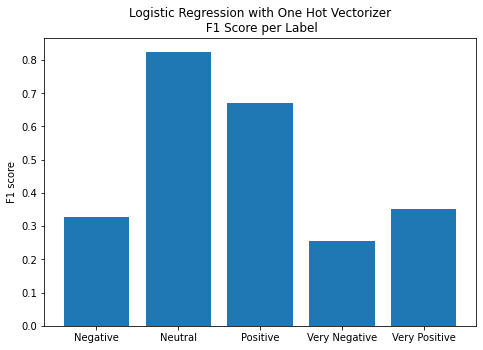

In [ ]:
from matplotlib import pyplot as plt

label = ['Negative','Neutral','Positive','Very Negative','Very Positive']

f1 = fbeta_score(lr_model_one_hot.predict(test_features_one_hot), test_labels ,1,average=None)


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(label,f1)
plt.title("Logistic Regression with One Hot Vectorizer\n F1 Score per Label")
plt.ylabel('F1 score')
plt.show()


## Q2 <br>



### Parameter Tuning

Logistic Regression Parameters:


*   C = [0.001,0.01,1,10,1000,10000,100000]



#### **Parameter**: C

In [ ]:
# Logistic Regression Parameters
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


parameter_C = {'lr_model__C': (0.001,0.01,1,10,1000,10000,100000)}


pipe = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize)), 
              ('lr_model', LogisticRegression())
              ])


grid_search = GridSearchCV(pipe, param_grid=parameter_C, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(train_data, train_labels)

print("pipeline:", [name for name, _ in pipe.steps])
print("parameters:")
print(parameter_C)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_C.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:  1.2min finished


pipeline: ['selector', 'tf-idf', 'lr_model']
parameters:
{'lr_model__C': (0.001, 0.01, 1, 10, 1000, 10000, 100000)}
Best score: 0.471
Best parameters set:
	lr_model__C: 10000


Vectorizer Parameters:

*   max_features = [None,1,10,100,1000,1300,2000,5000,10000,20000,30000,50000]
*   sublinear_tf = [True, False]
*   use_idf = [True, False]

#### **Parameter**: max_features

In [ ]:
parameter_max_features = {'tf-idf__max_features': (None,1,10,100,1000,1300,2000,5000,10000,20000,30000,50000)}

pipe = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf=False)), 
              ('lr_model', LogisticRegression(C=10000))
              ])



grid_search = GridSearchCV(pipe, param_grid=parameter_max_features, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(train_data, train_labels)

print("pipeline:", [name for name, _ in pipe.steps])
print("parameters:")
print(parameter_max_features)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_max_features.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.9min finished


pipeline: ['selector', 'tf-idf', 'lr_model']
parameters:
{'tf-idf__max_features': (None, 1, 10, 100, 1000, 1300, 2000, 5000, 10000, 20000, 30000, 50000)}
Best score: 0.477
Best parameters set:
	tf-idf__max_features: 2000


#### **Parameter**: sublinear_tf

In [ ]:
parameter_sublinear_tf = {'tf-idf__sublinear_tf': (True,False)}

pipe2 = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=2000)), 
              ('lr_model', LogisticRegression(C=10000))
              ])


grid_search = GridSearchCV(pipe2, param_grid=parameter_sublinear_tf, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(train_data, train_labels)

print("pipeline:", [name for name, _ in pipe2.steps])
print("parameters:")
print(parameter_sublinear_tf)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_sublinear_tf.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.2s finished


pipeline: ['selector', 'tf-idf', 'lr_model']
parameters:
{'tf-idf__sublinear_tf': (True, False)}
Best score: 0.477
Best parameters set:
	tf-idf__sublinear_tf: False


#### **Parameter**: use_idf

In [ ]:
parameter_use_idf = {'tf-idf__use_idf': (True,False)}
pipe = Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf-idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=2000,sublinear_tf = False)), 
              ('lr_model', LogisticRegression(C=10000))
              ])



grid_search = GridSearchCV(pipe, param_grid=parameter_use_idf, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(train_data, train_labels)

print("pipeline:", [name for name, _ in pipe.steps])
print("parameters:")
print(parameter_use_idf)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_use_idf.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.4s finished


pipeline: ['selector', 'tf-idf', 'lr_model']
parameters:
{'tf-idf__use_idf': (True, False)}
Best score: 0.477
Best parameters set:
	tf-idf__use_idf: True


Best Parameters:


*   Logistic Regression: C = 10000
*   TF-IDF: max_features = 2000
*   TF-IDF: sublinear_tf = False
*   TF_IDF: use_idf  = True




### Improved Model


In [ ]:
import warnings
warnings.filterwarnings('ignore')

tf_idf_vectorizer = TfidfVectorizer(tokenizer=tokenize_normalize,max_features=2000,sublinear_tf = False,use_idf=True)

train_features_tuning_model = tf_idf_vectorizer.fit_transform(train_data['body'].values.astype('U'))

validation_features_tuning_model = tf_idf_vectorizer.transform(validation_data['body'].values.astype('U'))
test_features_tuning_model = tf_idf_vectorizer.transform(test_data['body'].values.astype('U'))

lr_model_tuning = LogisticRegression(C=10000)
lr_model_tuning_tf_idf = lr_model_tuning.fit(train_features_tuning_model,train_labels)

evaluation_summary("Improved Logistic Regression with TF-IDF",lr_model_tuning_tf_idf.predict(test_features_tuning_model),test_labels)


Evaluation for: Improved Logistic Regression with TF-IDF
Classifier 'Improved Logistic Regression with TF-IDF' has 	 Acc=0.751 P=0.497 R=0.542 F1=0.517
               precision    recall  f1-score   support

     negative      0.390     0.468     0.426       235
      neutral      0.839     0.806     0.822      2614
     positive      0.690     0.708     0.699      1073
very negative      0.219     0.304     0.255        23
very positive      0.349     0.423     0.382        71

     accuracy                          0.751      4016
    macro avg      0.497     0.542     0.517      4016
 weighted avg      0.760     0.751     0.755      4016


Confusion matrix:
 [[ 110  159   10    2    1]
 [ 108 2108  264   14   20]
 [   6  316  760    0   20]
 [  11   13    1    7    0]
 [   0   18   38    0   30]]


### Error Analysis


In [ ]:
validation_prediction = lr_model_tuning_tf_idf.predict(validation_features_tuning_model)

data = {'Label_Sentiment_Polarity': validation_labels,
        'Body':validation_data['body'],
        'Prediction': validation_prediction,
        }

dataf = pd.DataFrame (data, columns = ['Label_Sentiment_Polarity','Body','Prediction'])

dataf.head(50)

,Label_Sentiment_Polarity,Body,Prediction
0,very positive,http://imgur.com/a/qmVd2\n\nThis is my entry f...,very positive
1,neutral,Cool stuff.\n\nOnly thing that stood out to me...,positive
2,very positive,Kinda awesome. What did you do it in?,very positive
3,neutral,"I used Maya, 3DCoat, Photoshop, and Unreal!",neutral
4,very positive,Awesome job.,very positive
5,very positive,that's awesome! wp =),very positive
6,positive,This is very cool.,positive
7,positive,very cool :),positive
8,neutral,Might just be me but the frog looks completely...,neutral
9,positive,I always see commercials where they advertise ...,neutral


In [ ]:
validation_prediction = lr_model_tuning_tf_idf.predict(validation_features_tuning_model)
evaluation_summary("Train Data:      Improved Logistic Regression with TF-IDF",lr_model_tuning_tf_idf.predict(train_features_tuning_model),train_labels,print_report=False)
evaluation_summary("Validation Data: Improved Logistic Regression with TF-IDF",lr_model_tuning_tf_idf.predict(validation_features_tuning_model),validation_labels,print_report=False)
evaluation_summary("Test Data:       Improved Logistic Regression with TF-IDF",lr_model_tuning_tf_idf.predict(test_features_tuning_model),test_labels,print_report=False)


Classifier 'Train Data:      Improved Logistic Regression with TF-IDF' has 	 Acc=0.916 P=0.875 R=0.912 F1=0.893
Classifier 'Validation Data: Improved Logistic Regression with TF-IDF' has 	 Acc=0.741 P=0.498 R=0.547 F1=0.518
Classifier 'Test Data:       Improved Logistic Regression with TF-IDF' has 	 Acc=0.751 P=0.497 R=0.542 F1=0.517


## Q3

Add two features to(try to) improve sentiment polarity classification performance


* Feature 1: FeatureUnion body + majority_type
* Feature 2: Word Embeddings




### Feature 1: FeatureUnion
body + majority_type



In [ ]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline

# Replace np.nan values of all the columns with empty string
train_data = train_data.replace(np.nan, ' ', regex=True)
validation_data = validation_data.replace(np.nan, ' ', regex=True)
test_data = test_data.replace(np.nan, ' ', regex=True)

# Use FeatureUnion to combine the features from body and majority_type
prediction_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=2000,sublinear_tf = False, use_idf=True)), 
              ])),
            ('majority_type', Pipeline([
              ('selector', ItemSelector(key='majority_type')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=2000,sublinear_tf = False, use_idf=True)), 
              ])),
        ])
        )
    ])

In [ ]:
train_features_tf_idf = prediction_pipeline.fit_transform(train_data)
validation_features_tf_idf = prediction_pipeline.transform(validation_data)
test_features_tf_df = prediction_pipeline.transform(test_data)

In [ ]:
lr_classifier = LogisticRegression(C=10000)
combined_lr_model = lr_classifier.fit(train_features_tf_idf,train_labels)
evaluation_summary("Combined LR TFIDF ", combined_lr_model.predict(test_features_tf_df), test_labels)     

Evaluation for: Combined LR TFIDF 
Classifier 'Combined LR TFIDF ' has 	 Acc=0.753 P=0.489 R=0.559 F1=0.517
               precision    recall  f1-score   support

     negative      0.362     0.468     0.408       218
      neutral      0.847     0.804     0.825      2648
     positive      0.690     0.712     0.700      1068
very negative      0.219     0.368     0.275        19
very positive      0.326     0.444     0.376        63

     accuracy                          0.753      4016
    macro avg      0.489     0.559     0.517      4016
 weighted avg      0.768     0.753     0.760      4016


Confusion matrix:
 [[ 102  167    9    3    1]
 [ 101 2129  260    9   15]
 [   5  318  760    0   19]
 [  10   15    0    7    0]
 [   0   19   39    0   28]]


### Feature 2: Word Embedding

In [ ]:
import gensim
from sklearn.base import BaseEstimator

class Estimator(BaseEstimator):

    def fit(self, X, y=None):
        """
        Accept input data, X, and optional target data, y. Returns self.
        """
        return self

    def predict(self, X):
        """
        Accept input data, X and return a vector of predictions for each row.
        """
        return yhat
      
# from sklearn.base import TransformerMixin

class Transfomer(BaseEstimator):

    def fit(self, X, y=None):
        """
        Learn how to transform data based on input data, X.
        """
        return self

    def transform(self, X):
        """
        Transform X into a new dataset, Xprime and return it.
        """
        return Xprime

In [ ]:
import numpy as np

from sklearn.base import BaseEstimator #, TransformerMixin

class MaximumEmbeddingVectorizer(BaseEstimator): #, TransformerMixin
    def __init__(self, embedding_model):
        self.embedding = embedding_model
        self.dimension = embedding_model.vector_size

    def fit(self, X,y):
        return self
      
    def transform(self, X):  
      # Skip OOV terms. Return 0 if no words are in the vocabulary.
      #print (X)
      return np.array([ 
          np.max([self.embedding[token] for token in doc if token in self.embedding]
                or [np.zeros(self.dimension)], axis=0)
          for doc in X
      ])

In [ ]:
import itertools

# train_data['body']

all_tokens_train = []
all_posts_tokenized_train = train_data.body.apply(tokenize_normalize)
all_tokens_train = list(itertools.chain.from_iterable(all_posts_tokenized_train))
print("Num tokens: ", len(all_tokens_train))


# validation_data['body']

all_tokens_validation = []
all_posts_tokenized_validation = validation_data.body.apply(tokenize_normalize)
all_tokens_validation = list(itertools.chain.from_iterable(all_posts_tokenized_validation))
print("Num tokens: ", len(all_tokens_validation))


# test_data['body']

all_tokens_test = []
all_posts_tokenized_test = test_data.body.apply(tokenize_normalize)
all_tokens_test = list(itertools.chain.from_iterable(all_posts_tokenized_test))
print("Num tokens: ", len(all_tokens_test))



Num tokens:  441771
Num tokens:  110772
Num tokens:  143978


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
 
# A function that given an input query item returns the top-k most similar items 
# by their cosine similarity.
# From lab 5
def find_similar(query_vector, vd_matrix, top_k = 5):
    cosine_similarities = cosine_similarity(query_vector, vd_matrix).flatten()
    related_doc_indices = cosine_similarities.argsort()[::-1]
    return [(index, cosine_similarities[index]) for index in related_doc_indices][0:top_k]

In [ ]:
import time

train_all_posts_tokenized = train_data.body.apply(tokenize_normalize)
test_all_posts_tokenized = test_data.body.apply(tokenize_normalize)

t0 = time.time()

train_model = gensim.models.Word2Vec(train_all_posts_tokenized, size=200, window=5, min_count=5, sg=0, alpha=0.025, iter=10, batch_words=10000)

t1 = time.time()
print ("Train Model Done in: %.02f s" % (t1 - t0))

Train Model Done in: 8.52 s


In [ ]:
def similiar_posts_feature(df, model, all_posts_tokenized,k=7):

  reddit_vectorizer = MaximumEmbeddingVectorizer(model)
  reddit_post_vector_matrix = reddit_vectorizer.transform(all_posts_tokenized)

  results = []
  for i,tokens in enumerate(all_posts_tokenized):

    transformed = reddit_vectorizer.transform([tokens])
    doc = transformed[0:1]

    similar_posts_string = ""
    count_similar=0
    for index, score in find_similar(doc, reddit_post_vector_matrix, k)[1:]:

      similar_post_polarity = df.iloc[index]['sentiment.polarity']

      # check the polarity of the similar post if equal with the polarity of the current post
      # Allow at maximum 2 post to be added on the 
      if similar_post_polarity == df.iloc[i]['sentiment.polarity']:

        count_similar+=1
        post_contents = df.iloc[index]['body'].replace('\n', ' ')
        similar_posts_string += post_contents

        # max 2 similar posts
        if count_similar == 2:
          break 

    results.append(similar_posts_string)
  return results

In [ ]:
train_similar_body = similiar_posts_feature(train_data,train_model,train_all_posts_tokenized)

test_similar_body = similiar_posts_feature(test_data,train_model,test_all_posts_tokenized)

In [ ]:
we_train_data = train_data.copy()
we_test_data = test_data.copy()

# add the new columns to the dataframes
we_train_data['Similar_Body'] = train_similar_body
we_test_data['Similar_Body'] = test_similar_body
we_train_data

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity,Similar_Body
0,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7f317,https://www.reddit.com/r/relationships/comment...,Melodrama_,"It's a sad realization, isn't it?",,False,2,t1_cy7erc5,negative,1.000000,
1,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hlyf,https://www.reddit.com/r/relationships/comment...,Melodrama_,I told her a couple of minutes ago that I didn...,elaboration,False,2,t1_cy7erc5,neutral,0.483631,"When I was 16, I was driving around town with ..."
2,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7etrr,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Leeches don't make good friends.,answer,False,1,t3_3xshx9,positive,0.600000,[Just make this plural](http://www.youtube.com...
3,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7hhpq,https://www.reddit.com/r/relationships/comment...,Melodrama_,I just ended it. Apparently she wasn't a good ...,elaboration,False,2,t1_cy7etrr,positive,0.475000,Duvernay was the one that passed on the projec...
4,relationships,My Friend/Crush [22/F] acting weird after I [2...,t1_cy7q0qg,https://www.reddit.com/r/relationships/comment...,TreatYoSelves,Good for you! Make sure you stick with it.,appreciation,False,3,t1_cy7hhpq,positive,0.744444,"If you're not paying for it, get it. Just make..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12133,reddit.com,"If I announced myself as God right now, would ...",t1_c1zpyd0,https://www.reddit.com/r/reddit.com/comments/h...,,"If you were God, you'd know whether we would b...",answer,False,1,t3_hzu51,neutral,0.000000,So say if Russia were to declare a war with th...
12134,reddit.com,"If I announced myself as God right now, would ...",t1_c1zpz7m,https://www.reddit.com/r/reddit.com/comments/h...,TheCannon,If I check my account balance in 5 minutes and...,answer,False,1,t3_hzu51,neutral,0.000000,If you can get it under $400 including all com...
12135,reddit.com,"If I announced myself as God right now, would ...",t1_c1zq0tl,https://www.reddit.com/r/reddit.com/comments/h...,alllie,I don't know. Can you heal the sick with a tou...,answer,False,1,t3_hzu51,negative,0.637202,
12136,reddit.com,"If I announced myself as God right now, would ...",t1_c1zq19j,https://www.reddit.com/r/reddit.com/comments/h...,TheCannon,... Give LeBron James a championship ring?,humor,False,2,t1_c1zq0tl,neutral,0.000000,"With objectives,buffs and everything balanced ..."


In [ ]:
pipe_word_embedding = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=2000,sublinear_tf = False, use_idf=True)), 
              ])),
            ('Similar_Body', Pipeline([
              ('selector', ItemSelector(key='Similar_Body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=2000,sublinear_tf = False, use_idf=True)), 
              ])),
        ])
        )
    ])

In [ ]:
train_features_tf_idf_word_embedding = pipe_word_embedding.fit_transform(we_train_data)
test_features_tf_idf_word_embedding = pipe_word_embedding.transform(we_test_data)

In [ ]:
word_embedding_train_labels = we_train_data['sentiment.polarity']
word_embedding_test_labels = we_test_data['sentiment.polarity']

lr_classifier = LogisticRegression(C=10000)
combined_lr_model_word_embedding = lr_classifier.fit(train_features_tf_idf_word_embedding,word_embedding_train_labels)
evaluation_summary("Combined LR TFIDF ", combined_lr_model_word_embedding.predict(test_features_tf_idf_word_embedding), word_embedding_test_labels)     

Evaluation for: Combined LR TFIDF 
Classifier 'Combined LR TFIDF ' has 	 Acc=0.840 P=0.668 R=0.668 F1=0.667
               precision    recall  f1-score   support

     negative      0.642     0.609     0.625       297
      neutral      0.892     0.899     0.896      2493
     positive      0.809     0.797     0.803      1119
very negative      0.531     0.472     0.500        36
very positive      0.465     0.563     0.510        71

     accuracy                          0.840      4016
    macro avg      0.668     0.668     0.667      4016
 weighted avg      0.840     0.840     0.839      4016


Confusion matrix:
 [[ 181   69   20    7    5]
 [  82 2242  172    6   12]
 [  17  174  892    5   14]
 [   7    6    2   17    0]
 [  10    2   33    1   40]]


### Combination of the Two Features 
FeatureUnion + Word Embedding

In [ ]:
# Replace np.nan with empty string
we_train_data = we_train_data.replace(np.nan, ' ', regex=True)
validation_data = validation_data.replace(np.nan, ' ', regex=True)
we_test_data = we_test_data.replace(np.nan, ' ', regex=True)
# Labels
f12_train_labels = we_train_data['sentiment.polarity']
f12_test_labels = we_test_data['sentiment.polarity']

f12_prediction_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=2000,sublinear_tf = False, use_idf=True)), 
              ])),
            ('majority_type', Pipeline([
              ('selector', ItemSelector(key='majority_type')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=2000,sublinear_tf = False, use_idf=True)), 
              ])),
            ('Similar_Body', Pipeline([
              ('selector', ItemSelector(key='Similar_Body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=2000,sublinear_tf = False, use_idf=True)), 
              ])),
        ])
        )
    ])

In [ ]:
f12_train_features_tf_idf = f12_prediction_pipeline.fit_transform(we_train_data)
f12_test_features_tf_idf = f12_prediction_pipeline.transform(we_test_data)

In [ ]:
lr_classifier = LogisticRegression(C=10000)
f12_combined_lr_model = lr_classifier.fit(f12_train_features_tf_idf,f12_train_labels)
evaluation_summary("Combined Features LR TFIDF ", f12_combined_lr_model.predict(f12_test_features_tf_idf), f12_test_labels)     

Evaluation for: Combined Features LR TFIDF 
Classifier 'Combined Features LR TFIDF ' has 	 Acc=0.845 P=0.662 R=0.675 F1=0.667
               precision    recall  f1-score   support

     negative      0.656     0.619     0.637       299
      neutral      0.899     0.902     0.900      2504
     positive      0.810     0.803     0.807      1112
very negative      0.469     0.441     0.455        34
very positive      0.477     0.612     0.536        67

     accuracy                          0.845      4016
    macro avg      0.662     0.675     0.667      4016
 weighted avg      0.845     0.845     0.845      4016


Confusion matrix:
 [[ 185   66   17    9    5]
 [  73 2259  165    7   10]
 [  23  172  893    3   11]
 [  10    5    2   15    0]
 [   8    2   35    0   41]]


(array([0, 1, 2, 3, 4]), <a list of 5 Text major ticklabel objects>)

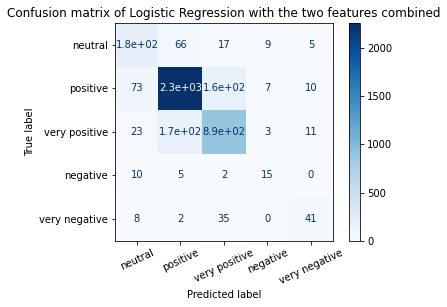

In [ ]:
from sklearn.metrics import plot_confusion_matrix

matrix = plot_confusion_matrix(f12_combined_lr_model,f12_test_features_tf_idf,f12_test_labels, display_labels=f12_test_labels.unique(),cmap=plt.cm.Blues)

plt.title("Confusion matrix of Logistic Regression with the two features combined")
plt.xticks(rotation=25)


# Part B: Thread Subreddit Prediction ##

In [ ]:
import pandas as pd

subreddit_train_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_discourse_train.json")
subreddit_test_data = pd.read_json("https://raw.githubusercontent.com/rpsoft/tad_course/main/reddit_discourse_test.json")

# Top 20 subreddits are filtered here for you.
top_subreddits = subreddit_train_data.subreddit.value_counts().head(20)

subreddit_train_data = subreddit_train_data[subreddit_train_data['subreddit'].isin(top_subreddits.keys())]
subreddit_test_data = subreddit_test_data[subreddit_test_data['subreddit'].isin(top_subreddits.keys())]
subreddit_train_data['post_depth'] = subreddit_train_data['post_depth'].astype(str)
subreddit_test_data['post_depth'] = subreddit_test_data['post_depth'].astype(str)

subreddit_train_data

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity
47,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t3_k6b28,https://www.reddit.com/r/starcraft/comments/k6...,mequals1m1w,"Edit: Unfortunately on GOM, match 6 & 7 are th...",announcement,True,0,,neutral,0.452143
48,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t1_c2htmv2,https://www.reddit.com/r/starcraft/comments/k6...,mequals1m1w,"That was indeed insane. Mass vikings, tanks, t...",agreement,False,2,t1_c2htm00,very negative,1.000000
49,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t1_c2htn2h,https://www.reddit.com/r/starcraft/comments/k6...,PrakPrak,this was like an action-packed version of Boxe...,appreciation,False,1,t3_k6b28,neutral,0.000000
50,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t1_c2htn9n,https://www.reddit.com/r/starcraft/comments/k6...,lO_O,Energyzer Byunny ran out of steam:(,,False,1,t3_k6b28,very negative,1.000000
51,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t1_c2htnhp,https://www.reddit.com/r/starcraft/comments/k6...,mequals1m1w,"It's too bad he landed vikings, was he low on ...",question,False,2,t1_c2htn9n,negative,0.483333
...,...,...,...,...,...,...,...,...,...,...,...,...
88446,askreddit,"Dear Reddit, what does the date May 18, 1967, ...",t1_c6j2ary,https://www.reddit.com/r/AskReddit/comments/11...,FromUnderABridge,absolutely nothing.,answer,False,1,t3_113tht,positive,0.900000
88447,askreddit,"Dear Reddit, what does the date May 18, 1967, ...",t1_c6j2at5,https://www.reddit.com/r/AskReddit/comments/11...,Ankyra,Here's [events that happened on the 18th of Ma...,answer,False,1,t3_113tht,neutral,0.000000
88448,askreddit,"Dear Reddit, what does the date May 18, 1967, ...",t1_c6j2ffe,https://www.reddit.com/r/AskReddit/comments/11...,marrklarr,that was the day when hippies everywhere decid...,answer,False,1,t3_113tht,neutral,0.000000
88449,askreddit,"Dear Reddit, what does the date May 18, 1967, ...",t1_c6j2hhn,https://www.reddit.com/r/AskReddit/comments/11...,EvanM07,The San Fancisco Giants lost 2-6 to the Housto...,answer,False,1,t3_113tht,negative,0.200000


In [ ]:
subreddit_train_data["subreddit"].value_counts()

askreddit               4134
leagueoflegends         2027
buildapc                1097
electronic_cigarette     961
pcmasterrace             742
trees                    738
gaming                   571
movies                   546
whowouldwin              497
guns                     497
relationships            481
atheism                  480
explainlikeimfive        453
starcraft                430
personalfinance          426
hockey                   420
loseit                   411
summonerschool           409
legaladvice              393
techsupport              389
Name: subreddit, dtype: int64

#### Training / Validation data

For part B the training is to be performed in a utilising cross-validation. See Lab 4 for an example, in particular the use of GridSearchCV.

## Q4

### Pre-Processing
Handle missing values

In [ ]:
def remove_body_nan_rows(df):
  """function to remove all the rows that their body column is nan"""
  columns = ['body']
  df = df.replace(r'^\s*$', np.nan, regex=True)
  for column in columns:
    df = df[pd.notnull(df[column])]
  return df

print("Empty/Null Values Before:")
print("Null Body Values=",subreddit_train_data['body'].isnull().values.sum())
print("Empty Body Values=",subreddit_test_data['body'].eq("").values.sum())

subreddit_train_data = remove_body_nan_rows(subreddit_train_data).copy()
subreddit_test_data = remove_body_nan_rows(subreddit_test_data).copy()

print("\nEmpty/Null Values After:")
print("Null Body Values=",subreddit_train_data['body'].isnull().values.sum())
print("Empty Body Values=",subreddit_test_data['body'].eq("").values.sum())



# print("Null Body Values=",f1_subreddit_train_data['Similar_Body'].eq("").values.sum())


Empty/Null Values Before:
Null Body Values= 0
Empty Body Values= 70

Empty/Null Values After:
Null Body Values= 0
Empty Body Values= 0


In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

Labels






In [ ]:
subreddit_train_labels = subreddit_train_data['subreddit']
subreddit_test_labels = subreddit_test_data['subreddit']

### Vectorizer

TF-IDF Vectorizer (on title,body,author) <br>
sublinear_tf=True

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer

subreddit_train_data = subreddit_train_data.replace(np.nan, ' ', regex=True)
subreddit_test_data = subreddit_test_data.replace(np.nan, ' ', regex=True)

subreddit_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
        ])
        )
    ])

In [ ]:
subreddit_train_features_tf_idf = subreddit_pipeline.fit_transform(subreddit_train_data)

subreddit_test_features_tf_df = subreddit_pipeline.transform(subreddit_test_data)


### Classifier
Logistic Regression
- L2 regularization
- C=10


In [ ]:
from sklearn.linear_model import LogisticRegression

subreddit_lr_classifier = LogisticRegression(C=10,penalty='l2')
subreddit_lr_model = subreddit_lr_classifier.fit(subreddit_train_features_tf_idf,subreddit_train_labels)

evaluation_summary("Subreddit LR TFIDF classifier ", subreddit_lr_model.predict(subreddit_test_features_tf_df), subreddit_test_labels)     

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Evaluation for: Subreddit LR TFIDF classifier 
Classifier 'Subreddit LR TFIDF classifier ' has 	 Acc=0.564 P=0.400 R=0.583 F1=0.435
                      precision    recall  f1-score   support

           askreddit      0.908     0.572     0.702      1555
             atheism      0.127     0.345     0.185        55
            buildapc      0.840     0.793     0.816       363
electronic_cigarette      0.434     0.632     0.515        68
   explainlikeimfive      0.339     0.474     0.396        78
              gaming      0.134     0.404     0.201        52
                guns      0.100     0.923     0.180        13
              hockey      0.327     0.877     0.476        57
     leagueoflegends      0.667     0.456     0.542       599
         legaladvice      0.667     1.000     0.800        10
              loseit      0.300     0.692     0.419        13
              movies      0.213     0.303     0.250        33
        pcmasterrace      0.155     0.216     0.181       134

### Three Classifiers chosen
1. SVC Classifier
2. Bernoulli Naive Bayes classifier
3. Decision Tree Classifier

#### i. SVC Classifier

In [ ]:
from sklearn.svm import SVC

subreddit_svc_classifier = SVC(kernel='rbf')
subreddit_svc_model_tf_idf = subreddit_svc_classifier.fit(subreddit_train_features_tf_idf,subreddit_train_labels)

evaluation_summary("Subreddit SVC Classifier with TF-IDF",  subreddit_svc_model_tf_idf.predict(subreddit_test_features_tf_df),subreddit_test_labels)

Evaluation for: Subreddit SVC Classifier with TF-IDF
Classifier 'Subreddit SVC Classifier with TF-IDF' has 	 Acc=0.516 P=0.275 R=0.436 F1=0.297
                      precision    recall  f1-score   support

           askreddit      0.931     0.523     0.670      1742
             atheism      0.053     0.800     0.100        10
            buildapc      0.813     0.773     0.793       361
electronic_cigarette      0.293     0.763     0.423        38
   explainlikeimfive      0.202     0.595     0.301        37
              gaming      0.089     0.667     0.157        21
                guns      0.000     0.000     0.000         0
              hockey      0.000     0.000     0.000         0
     leagueoflegends      0.726     0.357     0.479       832
         legaladvice      0.000     0.000     0.000         0
              loseit      0.000     0.000     0.000         0
              movies      0.213     0.270     0.238        37
        pcmasterrace      0.134     0.197     0.1

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### SVC Parameter Tuning

SVC Parameters:
- kernel = ['linear','poly','rbf','sigmoid','precomputed']
- C = [0.01,0.1,1,10,100]

In [ ]:
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')


parameter_kernel = {'svc__kernel':('linear','poly','rbf','sigmoid','precomputed')}


pipeline_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
        ])
        ),
        ('svc', SVC(C=10))
    ])


grid_search = GridSearchCV(pipeline_feature_union, param_grid=parameter_kernel, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(subreddit_train_data, subreddit_train_labels)

print("pipeline:", [name for name, _ in pipeline_feature_union.steps])
print("parameters:")
print(parameter_kernel)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_kernel.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  9.1min finished


pipeline: ['union', 'svc']
parameters:
{'svc__kernel': ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed')}
Best score: 0.346
Best parameters set:
	svc__kernel: 'sigmoid'


In [ ]:
import warnings
warnings.filterwarnings('ignore')

parameter_C = {'svc__C':  (0.01,0.1,1,10,100) }


pipeline_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
        ])
        ),
        ('svc', SVC(kernel='sigmoid'))
    ])


grid_search = GridSearchCV(pipeline_feature_union, param_grid=parameter_C, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(subreddit_train_data, subreddit_train_labels)

print("pipeline:", [name for name, _ in pipeline_feature_union.steps])
print("parameters:")
print(parameter_C)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_C.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))


Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  9.1min finished


pipeline: ['union', 'svc']
parameters:
{'svc__C': (0.01, 0.1, 1, 10, 100)}
Best score: 0.346
Best parameters set:
	svc__C: 10


Vectorizer Parameter
- max_features = [None,1,10,100,1000,1300,2000,5000,10000,20000,30000,50000]


In [ ]:
import warnings
warnings.filterwarnings('ignore')

parameter_max_features = {'union__body__tf_idf__max_features':  (None,1,10,100,1000,1300,2000,5000,10000,20000,30000,50000)}


pipeline_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
        ])
        ),
        ('svc', SVC(kernel='sigmoid'))
    ])


grid_search = GridSearchCV(pipeline_feature_union, param_grid=parameter_max_features, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(subreddit_train_data, subreddit_train_labels)

print("pipeline:", [name for name, _ in pipeline_feature_union.steps])
print("parameters:")
print(parameter_max_features)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_max_features.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))


Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 16.4min finished


pipeline: ['union', 'svc']
parameters:
{'union__body__tf_idf__max_features': (None, 1, 10, 100, 1000, 1300, 2000, 5000, 10000, 20000, 30000, 50000)}
Best score: 0.342
Best parameters set:
	union__body__tf_idf__max_features: 5000


##### Improved SVC Model
* Classifier Parameter
  - kernel = 'sigmoid'
  - C = 10

* Vectorizer Parameter
  - max_features = 5000

In [ ]:
SVC_subreddit_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
        ])
        )
    ])
SCV_subreddit_train_features_tf_idf = SVC_subreddit_pipeline.fit_transform(subreddit_train_data)

SCV_subreddit_test_features_tf_df = SVC_subreddit_pipeline.transform(subreddit_test_data)


In [ ]:
from sklearn.svm import SVC

subreddit_svc_classifier = SVC(kernel='sigmoid',C=10)
subreddit_svc_improved_model_tf_idf = subreddit_svc_classifier.fit(SCV_subreddit_train_features_tf_idf,subreddit_train_labels)

evaluation_summary("Subreddit SVC Classifier with TF-IDF",  subreddit_svc_improved_model_tf_idf.predict(SCV_subreddit_test_features_tf_df),subreddit_test_labels)

Evaluation for: Subreddit SVC Classifier with TF-IDF
Classifier 'Subreddit SVC Classifier with TF-IDF' has 	 Acc=0.535 P=0.355 R=0.518 F1=0.376
                      precision    recall  f1-score   support

           askreddit      0.891     0.584     0.706      1493
             atheism      0.113     0.405     0.177        42
            buildapc      0.776     0.760     0.768       350
electronic_cigarette      0.333     0.611     0.431        54
   explainlikeimfive      0.385     0.483     0.429        87
              gaming      0.242     0.469     0.319        81
                guns      0.008     0.250     0.016         4
              hockey      0.150     0.793     0.253        29
     leagueoflegends      0.670     0.394     0.496       696
         legaladvice      0.400     0.667     0.500         9
              loseit      0.100     0.500     0.167         6
              movies      0.447     0.266     0.333        79
        pcmasterrace      0.144     0.182     0.1

#### ii. Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
subreddit_nb_classifier = BernoulliNB()

subreddit_nb_model_tf_idf = subreddit_nb_classifier.fit(subreddit_train_features_tf_idf,subreddit_train_labels)

evaluation_summary("Bernoulli Naive Bayes with TF-IDF",  subreddit_nb_model_tf_idf.predict(subreddit_test_features_tf_df), subreddit_test_labels)

Evaluation for: Bernoulli Naive Bayes with TF-IDF
Classifier 'Bernoulli Naive Bayes with TF-IDF' has 	 Acc=0.433 P=0.179 R=0.652 F1=0.195
                      precision    recall  f1-score   support

           askreddit      0.984     0.389     0.557      2478
             atheism      0.013     1.000     0.026         2
            buildapc      0.583     0.680     0.628       294
electronic_cigarette      0.303     0.909     0.455        33
   explainlikeimfive      0.110     0.600     0.186        20
              gaming      0.006     0.500     0.013         2
                guns      0.000     0.000     0.000         0
              hockey      0.013     1.000     0.026         2
     leagueoflegends      0.575     0.424     0.488       554
         legaladvice      0.133     1.000     0.235         2
              loseit      0.133     0.800     0.229         5
              movies      0.021     1.000     0.042         1
        pcmasterrace      0.016     1.000     0.032    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Bernoulli Naive Bayes Parameter Tuning


BernoulliNB Parameters:
- fit_prior = [True,False]
- alpha = [0.001,0.005,0.01,0.015,0.019,0.02,0.022,1]


**Parameter** fit_prior

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV


parameter_fit_priorbool = {'NB__fit_prior': (True,False)}


pipeline_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
        ])
        ),
        ('NB', BernoulliNB())
    ])


grid_search = GridSearchCV(pipeline_feature_union, param_grid=parameter_fit_priorbool, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(subreddit_train_data, subreddit_train_labels)

print("pipeline:", [name for name, _ in pipeline_feature_union.steps])
print("parameters:")
print(parameter_fit_priorbool)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_fit_priorbool.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))


Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   28.0s finished


pipeline: ['union', 'NB']
parameters:
{'NB__fit_prior': (True, False)}
Best score: 0.135
Best parameters set:
	NB__fit_prior: False


**Parameter** alpha

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV


parameter_fit_priorbool = {'NB__alpha': (0.001,0.005,0.01,0.015,0.019,0.02,0.022,1)}


pipeline_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
        ])
        ),
        ('NB', BernoulliNB(fit_prior=False))
    ])


grid_search = GridSearchCV(pipeline_feature_union, param_grid=parameter_fit_priorbool, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(subreddit_train_data, subreddit_train_labels)

print("pipeline:", [name for name, _ in pipeline_feature_union.steps])
print("parameters:")
print(parameter_fit_priorbool)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_fit_priorbool.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))


Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  1.9min finished


pipeline: ['union', 'NB']
parameters:
{'NB__alpha': (0.001, 0.005, 0.01, 0.015, 0.02, 0.022, 0.019, 1)}
Best score: 0.446
Best parameters set:
	NB__alpha: 0.02


Vectorizer Parameter
- max_features = [None,1,10,100,1000,1300,2000,5000,10000,20000,30000,50000]


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV


parameter_max_features = {'union__body__tf_idf__max_features':  (None,1,10,100,1000,1300,2000,5000,10000,20000,30000,50000),
                    }


pipeline_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
        ])
        ),
        ('NB', BernoulliNB(alpha=0.02,fit_prior=False))
    ])


grid_search = GridSearchCV(pipeline_feature_union, param_grid=parameter_max_features, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(subreddit_train_data, subreddit_train_labels)

print("pipeline:", [name for name, _ in pipeline_feature_union.steps])
print("parameters:")
print(parameter_max_features)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_max_features.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  2.8min finished


pipeline: ['union', 'NB']
parameters:
{'union__body__tf_idf__max_features': (None, 1, 10, 100, 1000, 1300, 2000, 5000, 10000, 20000, 30000, 50000)}
Best score: 0.446
Best parameters set:
	union__body__tf_idf__max_features: None


##### Improved Bernoulli Naive Bayes and TF-IDF Vectorizer
* Classifier Parameter
  - alpha = 0.02
  - fit_prior = False
* Vectorizer Parameter
  - max_features = None

In [ ]:
from sklearn.naive_bayes import BernoulliNB

improved_subreddit_nb_classifier = BernoulliNB(alpha=0.02,fit_prior=False)

improved_bernoulli_subreddit_nb_model_tf_idf = improved_subreddit_nb_classifier.fit(subreddit_train_features_tf_idf,subreddit_train_labels)

evaluation_summary("Improved Bernoulli Naive Bayes with TF-IDF",  improved_bernoulli_subreddit_nb_model_tf_idf.predict(subreddit_test_features_tf_df), subreddit_test_labels)

Evaluation for: Improved Bernoulli Naive Bayes with TF-IDF
Classifier 'Improved Bernoulli Naive Bayes with TF-IDF' has 	 Acc=0.617 P=0.512 R=0.579 F1=0.515
                      precision    recall  f1-score   support

           askreddit      0.871     0.678     0.763      1258
             atheism      0.220     0.733     0.338        45
            buildapc      0.776     0.842     0.807       316
electronic_cigarette      0.596     0.663     0.628        89
   explainlikeimfive      0.523     0.456     0.487       125
              gaming      0.293     0.430     0.348       107
                guns      0.242     0.763     0.367        38
              hockey      0.595     0.929     0.725        98
     leagueoflegends      0.658     0.656     0.657       410
         legaladvice      0.733     0.550     0.629        20
              loseit      0.633     0.528     0.576        36
              movies      0.468     0.361     0.407        61
        pcmasterrace      0.364     0

#### iii. Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
subreddit_dtree_classifier = DecisionTreeClassifier(random_state=0)

subreddit_dtree_mode_tf_idf = subreddit_dtree_classifier.fit(subreddit_train_features_tf_idf,subreddit_train_labels)

evaluation_summary("Subreddit Decision Tree with TD-IDF",  subreddit_dtree_mode_tf_idf.predict(subreddit_test_features_tf_df), subreddit_test_labels)

Evaluation for: Subreddit Decision Tree with TD-IDF
Classifier 'Subreddit Decision Tree with TD-IDF' has 	 Acc=0.403 P=0.247 R=0.246 F1=0.234
                      precision    recall  f1-score   support

           askreddit      0.693     0.645     0.668      1051
             atheism      0.027     0.098     0.042        41
            buildapc      0.770     0.800     0.785       330
electronic_cigarette      0.172     0.239     0.200        71
   explainlikeimfive      0.055     0.056     0.055       108
              gaming      0.331     0.218     0.263       239
                guns      0.000     0.000     0.000         0
              hockey      0.000     0.000     0.000        10
     leagueoflegends      0.489     0.309     0.379       647
         legaladvice      0.133     0.045     0.068        44
              loseit      0.033     0.029     0.031        35
              movies      0.574     0.297     0.391        91
        pcmasterrace      0.134     0.139     0.136

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### Decision Tree Parameter Tuning

Decision tree Parameters:
- max_features = [None,'auto','sqrt','log2',5000,10000,15000,20000,25000,50000]
- random_state = [1,2,3,4]


**Parameter** max_features

In [ ]:
import warnings
warnings.filterwarnings('ignore')

parameter_max_features = {'decisionTree__max_features': (None,'auto','sqrt','log2',5000,10000,15000,20000,25000,50000)}


pipeline_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
        ])
        ),
        ('decisionTree', DecisionTreeClassifier())
    ])


grid_search = GridSearchCV(pipeline_feature_union, param_grid=parameter_max_features, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(subreddit_train_data, subreddit_train_labels)

print("pipeline:", [name for name, _ in pipeline_feature_union.steps])
print("parameters:")
print(parameter_max_features)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_max_features.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))



Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  2.3min finished


pipeline: ['union', 'decisionTree']
parameters:
{'decisionTree__max_features': (None, 'auto', 'sqrt', 'log2', 5000, 10000, 15000, 20000, 25000, 50000)}
Best score: 0.261
Best parameters set:
	decisionTree__max_features: 20000


**Paremeter** random_state

In [ ]:
import warnings
warnings.filterwarnings('ignore')

parameter_radnom_state = {'decisionTree__random_state': (1,2,3,4)}


pipeline_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
        ])
        ),
        ('decisionTree', DecisionTreeClassifier(max_features=20000))
    ])


grid_search = GridSearchCV(pipeline_feature_union, param_grid=parameter_radnom_state, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(subreddit_train_data, subreddit_train_labels)

print("pipeline:", [name for name, _ in pipeline_feature_union.steps])
print("parameters:")
print(parameter_radnom_state)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_radnom_state.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.2min finished


pipeline: ['union', 'decisionTree']
parameters:
{'decisionTree__random_state': (1, 2, 3, 4)}
Best score: 0.261
Best parameters set:
	decisionTree__random_state: 1


Vectorizer Parameter
- max_features = [None,1,10,100,1000,5000,10000,20000,50000,60000]


In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV


parameter_kernel = {'union__body__tf_idf__max_features':  (None,1,10,100,1000,5000,10000,20000,50000,60000),
                    }


pipeline_feature_union = Pipeline([
        ('union', FeatureUnion(
          [
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
        ])
        ),
        ('decisionTree', DecisionTreeClassifier(random_state=1,max_features=20000))
    ])


grid_search = GridSearchCV(pipeline_feature_union, param_grid=parameter_kernel, n_jobs=1, verbose=1, scoring='f1_macro', cv=2)
grid_search.fit(subreddit_train_data, subreddit_train_labels)

print("pipeline:", [name for name, _ in pipeline_feature_union.steps])
print("parameters:")
print(parameter_kernel)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameter_kernel.keys()):
  print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.9min finished


pipeline: ['union', 'decisionTree']
parameters:
{'union__body__tf_idf__max_features': (None, 1, 10, 100, 1000, 5000, 10000, 20000, 50000, 60000)}
Best score: 0.261
Best parameters set:
	union__body__tf_idf__max_features: None


##### Improved Decision Tree
* Classifier Parameter
  - max_features = 20000
  - random_state = 1
* Vectorizer Parameter
  - max_features = None

In [ ]:
improved_dt_subreddit_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize, sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize, sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize, sublinear_tf = True)), 
              ])),
        ])
        )
    ])

dt_subreddit_train_features_tf_idf = improved_dt_subreddit_pipeline.fit_transform(subreddit_train_data)

dt_subreddit_test_features_tf_df = improved_dt_subreddit_pipeline.transform(subreddit_test_data)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

subreddit_dtree_classifier = DecisionTreeClassifier(random_state=1,max_features=20000)

subreddit_dtree_mode_tf_idf = subreddit_dtree_classifier.fit(dt_subreddit_train_features_tf_idf,subreddit_train_labels)

evaluation_summary("Improved Subreddit Decision Tree with TD-IDF",  subreddit_dtree_mode_tf_idf.predict(dt_subreddit_test_features_tf_df), subreddit_test_labels)

Evaluation for: Improved Subreddit Decision Tree with TD-IDF
Classifier 'Improved Subreddit Decision Tree with TD-IDF' has 	 Acc=0.435 P=0.314 R=0.362 F1=0.314
                      precision    recall  f1-score   support

           askreddit      0.739     0.629     0.679      1150
             atheism      0.027     0.040     0.032       101
            buildapc      0.770     0.822     0.795       321
electronic_cigarette      0.081     0.127     0.099        63
   explainlikeimfive      0.275     0.217     0.243       138
              gaming      0.172     0.129     0.148       209
                guns      0.183     0.272     0.219        81
              hockey      0.248     0.704     0.367        54
     leagueoflegends      0.460     0.268     0.339       701
         legaladvice      0.667     0.400     0.500        25
              loseit      0.467     0.222     0.301        63
              movies      0.574     0.551     0.562        49
        pcmasterrace      0.134  

### Chosen Classifiers Performance on test data

In [ ]:
evaluation_summary("Subreddit Logistic Regression with TFIDF", subreddit_lr_model.predict(subreddit_test_features_tf_df), subreddit_test_labels,print_report=False) 
evaluation_summary("Improved SVC with TF-IDF\t\t\t",  subreddit_svc_improved_model_tf_idf.predict(SCV_subreddit_test_features_tf_df),subreddit_test_labels, print_report=False)    
evaluation_summary("Improved Bernoulli Naive Bayes with TF-IDF",  improved_bernoulli_subreddit_nb_model_tf_idf.predict(subreddit_test_features_tf_df), subreddit_test_labels,print_report=False)
evaluation_summary("Improved Decision Tree with TD-IDF\t\t",  subreddit_dtree_mode_tf_idf.predict(dt_subreddit_test_features_tf_df), subreddit_test_labels,print_report=False)

Classifier 'Subreddit Logistic Regression with TFIDF' has 	 Acc=0.564 P=0.400 R=0.583 F1=0.435
Classifier 'Improved SVC with TF-IDF			' has 	 Acc=0.535 P=0.355 R=0.518 F1=0.376
Classifier 'Improved Bernoulli Naive Bayes with TF-IDF' has 	 Acc=0.617 P=0.512 R=0.579 F1=0.515
Classifier 'Improved Decision Tree with TD-IDF		' has 	 Acc=0.435 P=0.314 R=0.362 F1=0.314


### Additional Features


#### Feature 1: Word Embedding 


In [ ]:
import gensim
from sklearn.base import BaseEstimator

class Estimator(BaseEstimator):

    def fit(self, X, y=None):
        """
        Accept input data, X, and optional target data, y. Returns self.
        """
        return self

    def predict(self, X):
        """
        Accept input data, X and return a vector of predictions for each row.
        """
        return yhat
      
# from sklearn.base import TransformerMixin

class Transfomer(BaseEstimator):

    def fit(self, X, y=None):
        """
        Learn how to transform data based on input data, X.
        """
        return self

    def transform(self, X):
        """
        Transform X into a new dataset, Xprime and return it.
        """
        return Xprime

In [ ]:
import numpy as np

from sklearn.base import BaseEstimator #, TransformerMixin

class MaximumEmbeddingVectorizer(BaseEstimator): #, TransformerMixin
    def __init__(self, embedding_model):
        self.embedding = embedding_model
        self.dimension = embedding_model.vector_size

    def fit(self, X,y):
        return self
      
    def transform(self, X):  
      # Skip OOV terms. Return 0 if no words are in the vocabulary.
      #print (X)
      return np.array([ 
          np.max([self.embedding[token] for token in doc if token in self.embedding]
                or [np.zeros(self.dimension)], axis=0)
          for doc in X
      ])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
 
# A function that given an input query item returns the top-k most similar items 
# by their cosine similarity.
# From lab 5
def find_similar(query_vector, vd_matrix, top_k = 5):
    cosine_similarities = cosine_similarity(query_vector, vd_matrix).flatten()
    related_doc_indices = cosine_similarities.argsort()[::-1]
    return [(index, cosine_similarities[index]) for index in related_doc_indices][0:top_k]

In [ ]:
def subreddit_similiar_posts_feature(df, model, all_posts_tokenized,k=15):

  reddit_vectorizer = MaximumEmbeddingVectorizer(model)
  reddit_post_vector_matrix = reddit_vectorizer.transform(all_posts_tokenized)

  results = []
  for i,tokens in enumerate(all_posts_tokenized):

    transformed = reddit_vectorizer.transform([tokens])
    doc = transformed[0:1]

    similar_posts_string = ""
    count_similar=0
    similar = find_similar(doc, reddit_post_vector_matrix, k)[1:]
    top1 = df.iloc[similar[0][0]]['body']
    top2 = df.iloc[similar[1][0]]['body']

    for index, score in similar:

      similar_post_subreddit = df.iloc[index]['subreddit']

      """
      check if the subreddit category of the similar posts is equal with the subreddit category of the current post
      allow bodies with the same subreddit category as the current/[i]th body
      allow at maximum 2 post to be added
      in case of an empty similar string, the two most similar ones, descpite the category, are chosen
      """
      
      if similar_post_subreddit == df.iloc[i]['subreddit']:

        count_similar+=1
        post_contents = df.iloc[index]['body'].replace('\n', ' ')
        similar_posts_string += post_contents

        # max 2 similar posts
        if count_similar == 2:
          break 

    if similar_posts_string=="":
      similar_posts_string = "{} {}".format(top1,top2)

    results.append(similar_posts_string)
  return results

In [ ]:
import time

train_all_posts_tokenized = subreddit_train_data.body.apply(tokenize_normalize)
test_all_posts_tokenized = subreddit_test_data.body.apply(tokenize_normalize)

t0 = time.time()

subreddit_train_model = gensim.models.Word2Vec(train_all_posts_tokenized, size=200, window=5, min_count=5, sg=0, alpha=0.025, iter=10, batch_words=10000)

t1 = time.time()
print ("Train Model Done in: %.02f s" % (t1 - t0))

Train Model Done in: 11.35 s


In [ ]:
t0 = time.time()

train_similar_body_1 = subreddit_similiar_posts_feature(subreddit_train_data,subreddit_train_model,train_all_posts_tokenized)
train_similar_body = train_similar_body_1
t1 = time.time()
print ("Train Model Done in: %.02f s" % (t1 - t0))

test_similar_body_1 = subreddit_similiar_posts_feature(subreddit_test_data,subreddit_train_model,test_all_posts_tokenized)
test_similar_body = test_similar_body_1
t2 = time.time()
print ("Train Model Done in: %.02f s" % (t2-t1))


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/us

Train Model Done in: 955.17 s


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/us

Train Model Done in: 88.06 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
f1_subreddit_train_data = subreddit_train_data.copy()
f1_subreddit_test_data = subreddit_test_data.copy()

# add the new columns to the dataframes
f1_subreddit_train_data['Similar_Body'] = train_similar_body
f1_subreddit_test_data['Similar_Body'] = test_similar_body
f1_subreddit_train_data

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity,comment_depth,Similar_Body
47,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t3_k6b28,https://www.reddit.com/r/starcraft/comments/k6...,mequals1m1w,"Edit: Unfortunately on GOM, match 6 & 7 are th...",announcement,True,0,,neutral,0.452143,0,"Hope you aren't being serious. And if you are,..."
48,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t1_c2htmv2,https://www.reddit.com/r/starcraft/comments/k6...,mequals1m1w,"That was indeed insane. Mass vikings, tanks, t...",agreement,False,2,t1_c2htm00,very negative,1.000000,1,"Even better, watch a VOD from [MLG Raleigh](ht..."
49,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t1_c2htn2h,https://www.reddit.com/r/starcraft/comments/k6...,PrakPrak,this was like an action-packed version of Boxe...,appreciation,False,1,t3_k6b28,neutral,0.000000,2,"That was indeed insane. Mass vikings, tanks, t..."
50,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t1_c2htn9n,https://www.reddit.com/r/starcraft/comments/k6...,lO_O,Energyzer Byunny ran out of steam:(,,False,1,t3_k6b28,very negative,1.000000,3,They ran out of history. Wiggle the way out of...
51,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t1_c2htnhp,https://www.reddit.com/r/starcraft/comments/k6...,mequals1m1w,"It's too bad he landed vikings, was he low on ...",question,False,2,t1_c2htn9n,negative,0.483333,4,Very true. I think that was happening early on...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88446,askreddit,"Dear Reddit, what does the date May 18, 1967, ...",t1_c6j2ary,https://www.reddit.com/r/AskReddit/comments/11...,FromUnderABridge,absolutely nothing.,answer,False,1,t3_113tht,positive,0.900000,15,Nothing.Yep. Absolutely.
88447,askreddit,"Dear Reddit, what does the date May 18, 1967, ...",t1_c6j2at5,https://www.reddit.com/r/AskReddit/comments/11...,Ankyra,Here's [events that happened on the 18th of Ma...,answer,False,1,t3_113tht,neutral,0.000000,16,**Mongol General**: Conan! What is best in lif...
88448,askreddit,"Dear Reddit, what does the date May 18, 1967, ...",t1_c6j2ffe,https://www.reddit.com/r/AskReddit/comments/11...,marrklarr,that was the day when hippies everywhere decid...,answer,False,1,t3_113tht,neutral,0.000000,17,I was alive in the year 2000 and I am still mo...
88449,askreddit,"Dear Reddit, what does the date May 18, 1967, ...",t1_c6j2hhn,https://www.reddit.com/r/AskReddit/comments/11...,EvanM07,The San Fancisco Giants lost 2-6 to the Housto...,answer,False,1,t3_113tht,negative,0.200000,18,I live two houses down from a BBQ restaurant a...


Vectorizer for Feature 1

In [ ]:
f1_subreddit_pipe = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('Similar_Body', Pipeline([
              ('selector', ItemSelector(key='Similar_Body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
        ])
        )
    ])

In [ ]:
f1_SVC_subreddit_pipe = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
            ('Similar_Body', Pipeline([
              ('selector', ItemSelector(key='Similar_Body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
        ])
        )
    ])

Labels for Feature 1

In [ ]:
# vectorizer for all classifiers except SVC
f1_subreddit_train_features = f1_subreddit_pipe.fit_transform(f1_subreddit_train_data)
f1_subreddit_test_features = f1_subreddit_pipe.transform(f1_subreddit_test_data)

# SVC vectorizer
f1_SVC_subreddit_train_features = f1_SVC_subreddit_pipe.fit_transform(f1_subreddit_train_data)
f1_SVC_subreddit_test_features = f1_SVC_subreddit_pipe.transform(f1_subreddit_test_data)

f1_subreddit_train_labels = f1_subreddit_train_data['subreddit']
f1_subreddit_test_labels = f1_subreddit_test_data['subreddit']

**Word Embeddings using SVC Classifier**

In [ ]:
from sklearn.svm import SVC

f1_subreddit_svc_classifier = SVC(kernel='sigmoid',C=10)
f1_subreddit_svc_model_tf_idf = f1_subreddit_svc_classifier.fit(f1_SVC_subreddit_train_features, f1_subreddit_train_labels)

evaluation_summary("Feature 1: Subreddit SVC Classifier with TF-IDF",  f1_subreddit_svc_model_tf_idf.predict(f1_SVC_subreddit_test_features),f1_subreddit_test_labels)

Evaluation for: Feature 1: Subreddit SVC Classifier with TF-IDF
Classifier 'Feature 1: Subreddit SVC Classifier with TF-IDF' has 	 Acc=0.549 P=0.373 R=0.572 F1=0.402
                      precision    recall  f1-score   support

           askreddit      0.903     0.579     0.706      1526
             atheism      0.160     0.585     0.251        41
            buildapc      0.822     0.783     0.802       360
electronic_cigarette      0.323     0.653     0.432        49
   explainlikeimfive      0.422     0.590     0.492        78
              gaming      0.197     0.492     0.282        63
                guns      0.000     0.000     0.000        10
              hockey      0.092     0.737     0.163        19
     leagueoflegends      0.731     0.417     0.531       717
         legaladvice      0.600     1.000     0.750         9
              loseit      0.100     0.750     0.176         4
              movies      0.553     0.394     0.460        66
        pcmasterrace      0

**Word Embeddings using BernoulliNB Classifier**

In [ ]:
from sklearn.naive_bayes import BernoulliNB

f1_subreddit_nb_classifier = BernoulliNB(alpha=0.02,fit_prior=False)

subreddit_nb_model_tf_idf = f1_subreddit_nb_classifier.fit(f1_subreddit_train_features,f1_subreddit_train_labels)

evaluation_summary("Feature 1: Bernoulli Naive Bayes with TF-IDF",  subreddit_nb_model_tf_idf.predict(f1_subreddit_test_features), f1_subreddit_test_labels)


Evaluation for: Feature 1: Bernoulli Naive Bayes with TF-IDF
Classifier 'Feature 1: Bernoulli Naive Bayes with TF-IDF' has 	 Acc=0.578 P=0.461 R=0.544 F1=0.461
                      precision    recall  f1-score   support

           askreddit      0.847     0.686     0.758      1209
             atheism      0.233     0.636     0.341        55
            buildapc      0.630     0.854     0.725       253
electronic_cigarette      0.535     0.639     0.582        83
   explainlikeimfive      0.495     0.450     0.472       120
              gaming      0.299     0.470     0.366       100
                guns      0.242     0.644     0.352        45
              hockey      0.562     0.945     0.705        91
     leagueoflegends      0.638     0.698     0.667       374
         legaladvice      0.533     0.222     0.314        36
              loseit      0.367     0.344     0.355        32
              movies      0.468     0.415     0.440        53
        pcmasterrace      0.364  

**Word Embeddings using Decision Tree Classifier**

In [ ]:
f1_subreddit_dtree_classifier = DecisionTreeClassifier(random_state=1,max_features=20000)

f1_subreddit_dtree_mode_tf_idf = f1_subreddit_dtree_classifier.fit(f1_subreddit_train_features,f1_subreddit_train_labels)

evaluation_summary("Feature 1: Subreddit Decision Tree with TD-IDF",  f1_subreddit_dtree_mode_tf_idf.predict(f1_subreddit_test_features), f1_subreddit_test_labels)

Evaluation for: Feature 1: Subreddit Decision Tree with TD-IDF
Classifier 'Feature 1: Subreddit Decision Tree with TD-IDF' has 	 Acc=0.379 P=0.233 R=0.230 F1=0.222
                      precision    recall  f1-score   support

           askreddit      0.669     0.565     0.612      1160
             atheism      0.067     0.294     0.109        34
            buildapc      0.790     0.742     0.766       365
electronic_cigarette      0.101     0.119     0.109        84
   explainlikeimfive      0.083     0.100     0.090        90
              gaming      0.051     0.051     0.051       156
                guns      0.050     0.065     0.057        92
              hockey      0.072     0.208     0.107        53
     leagueoflegends      0.396     0.257     0.312       630
         legaladvice      0.133     0.077     0.098        26
              loseit      0.033     0.036     0.034        28
              movies      0.851     0.500     0.630        80
        pcmasterrace      0.1

<a name="1"></a>


#### Feature 2: FeatureUnion - Post Depth 

Using FeatureUnion combine the columns `title`,`author`,`body` and `post_depth`

In [ ]:
subreddit_train_data

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity,comment_depth
47,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t3_k6b28,https://www.reddit.com/r/starcraft/comments/k6...,mequals1m1w,"Edit: Unfortunately on GOM, match 6 & 7 are th...",announcement,True,0,,neutral,0.452143,0
48,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t1_c2htmv2,https://www.reddit.com/r/starcraft/comments/k6...,mequals1m1w,"That was indeed insane. Mass vikings, tanks, t...",agreement,False,2,t1_c2htm00,very negative,1.000000,1
49,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t1_c2htn2h,https://www.reddit.com/r/starcraft/comments/k6...,PrakPrak,this was like an action-packed version of Boxe...,appreciation,False,1,t3_k6b28,neutral,0.000000,2
50,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t1_c2htn9n,https://www.reddit.com/r/starcraft/comments/k6...,lO_O,Energyzer Byunny ran out of steam:(,,False,1,t3_k6b28,very negative,1.000000,3
51,starcraft,Byun vs SuperNova - Mass TvT incoming with eve...,t1_c2htnhp,https://www.reddit.com/r/starcraft/comments/k6...,mequals1m1w,"It's too bad he landed vikings, was he low on ...",question,False,2,t1_c2htn9n,negative,0.483333,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88446,askreddit,"Dear Reddit, what does the date May 18, 1967, ...",t1_c6j2ary,https://www.reddit.com/r/AskReddit/comments/11...,FromUnderABridge,absolutely nothing.,answer,False,1,t3_113tht,positive,0.900000,15
88447,askreddit,"Dear Reddit, what does the date May 18, 1967, ...",t1_c6j2at5,https://www.reddit.com/r/AskReddit/comments/11...,Ankyra,Here's [events that happened on the 18th of Ma...,answer,False,1,t3_113tht,neutral,0.000000,16
88448,askreddit,"Dear Reddit, what does the date May 18, 1967, ...",t1_c6j2ffe,https://www.reddit.com/r/AskReddit/comments/11...,marrklarr,that was the day when hippies everywhere decid...,answer,False,1,t3_113tht,neutral,0.000000,17
88449,askreddit,"Dear Reddit, what does the date May 18, 1967, ...",t1_c6j2hhn,https://www.reddit.com/r/AskReddit/comments/11...,EvanM07,The San Fancisco Giants lost 2-6 to the Housto...,answer,False,1,t3_113tht,negative,0.200000,18


Vectorizer for Feature 2

In [ ]:
f2_subreddit_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('post_depth', Pipeline([
              ('selector', ItemSelector(key='post_depth')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,lowercase = False,sublinear_tf = True)), 
              ])),
        ])
        )
    ])

f2_SVC_subreddit_pipe = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
            ('post_depth', Pipeline([
              ('selector', ItemSelector(key='post_depth')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,lowercase=False,sublinear_tf = True)), 
              ])),
        ])
        )
    ])



In [ ]:
f2_subreddit_train_features_tf_idf = f2_subreddit_pipeline.fit_transform(subreddit_train_data)
f2_subreddit_test_features_tf_df = f2_subreddit_pipeline.transform(subreddit_test_data)

# SVC Features
f2_SVC_subreddit_train_features_tf_idf = f2_SVC_subreddit_pipe.fit_transform(subreddit_train_data)
f2_SVC_subreddit_test_features_tf_df = f2_SVC_subreddit_pipe.transform(subreddit_test_data)


F2 Labels

In [ ]:
f2_subreddit_train_labels = subreddit_train_data['subreddit']
f2_subreddit_test_labels = subreddit_test_data['subreddit']

**Feature 2 using SVC Classifier**

In [ ]:
from sklearn.svm import SVC

f2_subreddit_svc_classifier = SVC(kernel='sigmoid',C=10)
f2_subreddit_svc_model_tf_idf = f2_subreddit_svc_classifier.fit(f2_SVC_subreddit_train_features_tf_idf, f2_subreddit_train_labels)

evaluation_summary("Feature 2: Subreddit SVC Classifier with TF-IDF",  f2_subreddit_svc_model_tf_idf.predict(f2_SVC_subreddit_test_features_tf_df),f2_subreddit_test_labels)

Evaluation for: Feature 2: Subreddit SVC Classifier with TF-IDF
Classifier 'Feature 2: Subreddit SVC Classifier with TF-IDF' has 	 Acc=0.522 P=0.334 R=0.496 F1=0.359
                      precision    recall  f1-score   support

           askreddit      0.879     0.580     0.699      1484
             atheism      0.153     0.442     0.228        52
            buildapc      0.813     0.744     0.777       375
electronic_cigarette      0.293     0.537     0.379        54
   explainlikeimfive      0.404     0.494     0.444        89
              gaming      0.191     0.405     0.260        74
                guns      0.017     0.118     0.029        17
              hockey      0.222     0.850     0.352        40
     leagueoflegends      0.631     0.392     0.483       659
         legaladvice      0.267     0.400     0.320        10
              loseit      0.167     0.625     0.263         8
              movies      0.426     0.230     0.299        87
        pcmasterrace      0


**Feature 2 using Bernoulli Naive Bayes**


In [ ]:
from sklearn.naive_bayes import BernoulliNB

f2_subreddit_nb_classifier = BernoulliNB(alpha=0.02,fit_prior=False)

subreddit_nb_model_tf_idf = f2_subreddit_nb_classifier.fit(f2_subreddit_train_features_tf_idf,f2_subreddit_train_labels)

evaluation_summary("Feature 2: Bernoulli Naive Bayes with TF-IDF",  subreddit_nb_model_tf_idf.predict(f2_subreddit_test_features_tf_df), f2_subreddit_test_labels)

f2_subreddit_train_features_tf_idf = f2_subreddit_pipeline.fit_transform(subreddit_train_data)
f2_subreddit_test_features_tf_df = f2_subreddit_pipeline.transform(subreddit_test_data)


Evaluation for: Feature 2: Bernoulli Naive Bayes with TF-IDF
Classifier 'Feature 2: Bernoulli Naive Bayes with TF-IDF' has 	 Acc=0.618 P=0.515 R=0.580 F1=0.519
                      precision    recall  f1-score   support

           askreddit      0.869     0.681     0.764      1249
             atheism      0.213     0.744     0.332        43
            buildapc      0.773     0.844     0.807       314
electronic_cigarette      0.606     0.674     0.638        89
   explainlikeimfive      0.541     0.465     0.500       127
              gaming      0.293     0.434     0.350       106
                guns      0.267     0.762     0.395        42
              hockey      0.601     0.920     0.727       100
     leagueoflegends      0.655     0.652     0.654       411
         legaladvice      0.733     0.550     0.629        20
              loseit      0.633     0.543     0.585        35
              movies      0.468     0.367     0.411        60
        pcmasterrace      0.374  

**Feature 2 using Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

f2_subreddit_dtree_classifier = DecisionTreeClassifier(random_state=1,max_features=20000)

f2_subreddit_dtree_mode_tf_idf = f2_subreddit_dtree_classifier.fit(f2_subreddit_train_features_tf_idf,f2_subreddit_train_labels)

evaluation_summary("Feature 2: Subreddit Decision Tree with TD-IDF",  f2_subreddit_dtree_mode_tf_idf.predict(f2_subreddit_test_features_tf_df), f2_subreddit_test_labels)

Evaluation for: Feature 2: Subreddit Decision Tree with TD-IDF
Classifier 'Feature 2: Subreddit Decision Tree with TD-IDF' has 	 Acc=0.387 P=0.207 R=0.204 F1=0.202
                      precision    recall  f1-score   support

           askreddit      0.721     0.657     0.688      1074
             atheism      0.027     0.043     0.033        93
            buildapc      0.781     0.724     0.752       370
electronic_cigarette      0.141     0.116     0.127       121
   explainlikeimfive      0.018     0.014     0.016       140
              gaming      0.127     0.134     0.131       149
                guns      0.000     0.000     0.000        12
              hockey      0.000     0.000     0.000         9
     leagueoflegends      0.452     0.332     0.383       558
         legaladvice      0.000     0.000     0.000        13
              loseit      0.033     0.059     0.043        17
              movies      0.574     0.466     0.514        58
        pcmasterrace      0.1

#### Combination of the two features

Combine Word Embeddings with FeatureUnion (post_depth)


In [ ]:
subreddit_train_data = f1_subreddit_train_data
subreddit_test_data = f1_subreddit_test_data
subreddit_test_data

,subreddit,title,id,url,author,body,majority_type,is_first_post,post_depth,in_reply_to,sentiment.polarity,sentiment.subjectivity,comment_depth,Similar_Body
55,askreddit,What is the stupidest thing Peer Pressure has ...,t1_c5phigu,https://www.reddit.com/r/AskReddit/comments/xt...,justa_flesh_wound,Smoking. \n\nStarted in college('06) while dri...,answer,False,1,t3_xtqrd,positive,0.375,1,That's like asking a parent to pick a favorite...
56,askreddit,What is the stupidest thing Peer Pressure has ...,t1_c5phl29,https://www.reddit.com/r/AskReddit/comments/xt...,wow2424,Smoking. \nIm on day 3 of quitting.,answer,False,1,t3_xtqrd,neutral,0.000,2,Actor. I take care of actors now. Close enough...
57,askreddit,What is the stupidest thing Peer Pressure has ...,t1_c5phokx,https://www.reddit.com/r/AskReddit/comments/xt...,,Murdering Sarah Jessica Parker.,humor,False,1,t3_xtqrd,neutral,0.000,3,PittsburghBenny Hill. Boobs.
58,askreddit,What is the stupidest thing Peer Pressure has ...,t1_c5phhj2,https://www.reddit.com/r/AskReddit/comments/xt...,thefootballlplatypus,Mine was jumping off the roof of his house ont...,answer,False,1,t3_xtqrd,neutral,0.000,4,One of the ones that come to mind for me was a...
59,askreddit,What is the stupidest thing Peer Pressure has ...,t1_c5phm0l,https://www.reddit.com/r/AskReddit/comments/xt...,detailed_fred,Going to clubs.,answer,False,1,t3_xtqrd,neutral,0.000,5,"Yeah. MAC-Arthur to the teeth!Sorta both, its..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21937,buildapc,Is this an ATX or Micro-ATX Mobo?,t1_cnry31d,https://www.reddit.com/r/buildapc/comments/2sq...,Amgara,I'm actually the one who placed the ram. I'm a...,question,False,4,t1_cnrxz8x,neutral,0.100,19,This build is almost exact to mine except I we...
21938,buildapc,Is this an ATX or Micro-ATX Mobo?,t1_cnry60m,https://www.reddit.com/r/buildapc/comments/2sq...,Jakomako,They usually want to go in alternating slots f...,answer,False,5,t1_cnry31d,negative,0.250,20,As others have said GPUBoss is biased and not ...
21939,buildapc,Is this an ATX or Micro-ATX Mobo?,t1_cnry3hw,https://www.reddit.com/r/buildapc/comments/2sq...,chopdok,"Its 6 GB, so I am assuming 4+2, hence doesn't ...",elaboration,False,4,t1_cnrxz8x,neutral,0.000,21,I've been considering the 8 GB for a while now...
21940,buildapc,Is this an ATX or Micro-ATX Mobo?,t1_cnry657,https://www.reddit.com/r/buildapc/comments/2sq...,Jakomako,"Ah, good point.",agreement,False,5,t1_cnry3hw,positive,0.600,22,"Okay, looks good then. Yep, a very good choice"


Vectorizer

In [ ]:
f12_subreddit_pipeline = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
            ('post_depth', Pipeline([
              ('selector', ItemSelector(key='post_depth')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,lowercase = False,sublinear_tf = True)), 
              ])),
            ('Similar_Body', Pipeline([
              ('selector', ItemSelector(key='Similar_Body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,sublinear_tf = True)), 
              ])),
        ])
        )
    ])

f12_SVC_subreddit_pipe = Pipeline([
        ('union', FeatureUnion(
          transformer_list=[
            ('title', Pipeline([
              ('selector', ItemSelector(key='title')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
            ('body', Pipeline([
              ('selector', ItemSelector(key='body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
            ('author', Pipeline([
              ('selector', ItemSelector(key='author')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
            ('post_depth', Pipeline([
              ('selector', ItemSelector(key='post_depth')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,lowercase=False,sublinear_tf = True)), 
              ])),
            ('Similar_Body', Pipeline([
              ('selector', ItemSelector(key='Similar_Body')),
              ('tf_idf', TfidfVectorizer(tokenizer=tokenize_normalize,max_features=5000,sublinear_tf = True)), 
              ])),
        ])
        )
    ])



In [ ]:
f12_subreddit_train_features_tf_idf = f12_subreddit_pipeline.fit_transform(subreddit_train_data)
f12_subreddit_test_features_tf_df = f12_subreddit_pipeline.transform(subreddit_test_data)

# SVC Features
f12_SVC_subreddit_train_features_tf_idf = f12_SVC_subreddit_pipe.fit_transform(subreddit_train_data)
f12_SVC_subreddit_test_features_tf_df = f12_SVC_subreddit_pipe.transform(subreddit_test_data)

Labels

In [ ]:
f12_subreddit_train_labels = subreddit_train_data['subreddit']
f12_subreddit_test_labels = subreddit_test_data['subreddit']

**Combined Features using SVC Classifier**

In [ ]:
from sklearn.svm import SVC

f1_subreddit_svc_classifier = SVC(kernel='sigmoid',C=10)
f1_subreddit_svc_model_tf_idf = f1_subreddit_svc_classifier.fit(f1_SVC_subreddit_train_features, f1_subreddit_train_labels)

evaluation_summary("Feature 1: Train Data Subreddit SVC Classifier with TF-IDF",  f1_subreddit_svc_model_tf_idf.predict(f1_SVC_subreddit_test_features),f1_subreddit_test_labels, print_report = False)
evaluation_summary("Feature 1: Test Data Subreddit SVC Classifier with TF-IDF",  f1_subreddit_svc_model_tf_idf.predict(f1_SVC_subreddit_test_features),f1_subreddit_test_labels)


Classifier 'Feature 1: Train Data Subreddit SVC Classifier with TF-IDF' has 	 Acc=0.549 P=0.373 R=0.572 F1=0.402
Evaluation for: Feature 1: Test Data Subreddit SVC Classifier with TF-IDF
Classifier 'Feature 1: Test Data Subreddit SVC Classifier with TF-IDF' has 	 Acc=0.549 P=0.373 R=0.572 F1=0.402
                      precision    recall  f1-score   support

           askreddit      0.903     0.579     0.706      1526
             atheism      0.160     0.585     0.251        41
            buildapc      0.822     0.783     0.802       360
electronic_cigarette      0.323     0.653     0.432        49
   explainlikeimfive      0.422     0.590     0.492        78
              gaming      0.197     0.492     0.282        63
                guns      0.000     0.000     0.000        10
              hockey      0.092     0.737     0.163        19
     leagueoflegends      0.731     0.417     0.531       717
         legaladvice      0.600     1.000     0.750         9
              lose

**Combined Features using BernoulliNB**

In [ ]:
from sklearn.naive_bayes import BernoulliNB

f1_subreddit_nb_classifier = BernoulliNB(alpha=0.02,fit_prior=False)

subreddit_nb_model_tf_idf = f1_subreddit_nb_classifier.fit(f1_subreddit_train_features,f1_subreddit_train_labels)

evaluation_summary("Feature 1: Train Data Bernoulli Naive Bayes with TF-IDF",  subreddit_nb_model_tf_idf.predict(f1_subreddit_train_features), f1_subreddit_train_labels, print_report=False)
evaluation_summary("Feature 1: Test Data Bernoulli Naive Bayes with TF-IDF",  subreddit_nb_model_tf_idf.predict(f1_subreddit_test_features), f1_subreddit_test_labels)


Classifier 'Feature 1: Train Data Bernoulli Naive Bayes with TF-IDF' has 	 Acc=0.934 P=0.914 R=0.933 F1=0.922
Evaluation for: Feature 1: Test Data Bernoulli Naive Bayes with TF-IDF
Classifier 'Feature 1: Test Data Bernoulli Naive Bayes with TF-IDF' has 	 Acc=0.578 P=0.461 R=0.544 F1=0.461
                      precision    recall  f1-score   support

           askreddit      0.847     0.686     0.758      1209
             atheism      0.233     0.636     0.341        55
            buildapc      0.630     0.854     0.725       253
electronic_cigarette      0.535     0.639     0.582        83
   explainlikeimfive      0.495     0.450     0.472       120
              gaming      0.299     0.470     0.366       100
                guns      0.242     0.644     0.352        45
              hockey      0.562     0.945     0.705        91
     leagueoflegends      0.638     0.698     0.667       374
         legaladvice      0.533     0.222     0.314        36
              loseit      0

**Combined Features using Decision Tree**

In [ ]:
f1_subreddit_dtree_classifier = DecisionTreeClassifier(random_state=1,max_features=20000)

f1_subreddit_dtree_mode_tf_idf = f1_subreddit_dtree_classifier.fit(f1_subreddit_train_features,f1_subreddit_train_labels)

evaluation_summary("Feature 1: Train Data Subreddit Decision Tree with TD-IDF",  f1_subreddit_dtree_mode_tf_idf.predict(f1_subreddit_train_features), f1_subreddit_train_labels, print_report=False)
evaluation_summary("Feature 1: Test Data Subreddit Decision Tree with TD-IDF",  f1_subreddit_dtree_mode_tf_idf.predict(f1_subreddit_test_features), f1_subreddit_test_labels)


Classifier 'Feature 1: Train Data Subreddit Decision Tree with TD-IDF' has 	 Acc=1.000 P=1.000 R=1.000 F1=1.000
Evaluation for: Feature 1: Test Data Subreddit Decision Tree with TD-IDF
Classifier 'Feature 1: Test Data Subreddit Decision Tree with TD-IDF' has 	 Acc=0.379 P=0.233 R=0.230 F1=0.222
                      precision    recall  f1-score   support

           askreddit      0.669     0.565     0.612      1160
             atheism      0.067     0.294     0.109        34
            buildapc      0.790     0.742     0.766       365
electronic_cigarette      0.101     0.119     0.109        84
   explainlikeimfive      0.083     0.100     0.090        90
              gaming      0.051     0.051     0.051       156
                guns      0.050     0.065     0.057        92
              hockey      0.072     0.208     0.107        53
     leagueoflegends      0.396     0.257     0.312       630
         legaladvice      0.133     0.077     0.098        26
              loseit 